In [1]:
import pandas as pd
import numpy as np
import shap
import torch
from torch import nn
import scipy.stats
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import ast

import json
import xmltodict

import stable_baselines3

from agents.actor_critic_agent import CustomActorCritic
from agents.option_networks import ReluNetwork
from collections import defaultdict

import math

/home/ruben/Documents/virtualenv/vub_sdms/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BASE_FOLDER = './evaluations'
MODEL_HIGH = "a2c_custom-2way-single-intersection-high_100000_steps"
MODEL_LOW = "a2c_custom-2way-single-intersection-low_100000_steps"

In [3]:
def to_tensor(obs):
    obs = np.asarray(obs)
    obs = torch.from_numpy(obs).float()
    return obs


    

def load_data(prefix, traffic):
    with open(f"./meta/{traffic}.json") as f:
        meta_data = json.load(f)
    def translate_action(action_dict):
        # TODO: add fix in evaluate script
        action_dict = ast.literal_eval(action_dict)
        if not isinstance(action_dict, dict):
            action_dict = {"t": action_dict[0]}
        green = []
        for tf_id, p in action_dict.items():
            green_tf = f"{tf_id}:"
            green_tf += ", ".join(meta_data[tf_id]["phases"][str(p)]["lanes_green"])
            green.append(green_tf)
        return "; ".join(green)
    print("Loading", f'{BASE_FOLDER}/{prefix}_{traffic}_1_episode.csv')
    df_single_episode = pd.read_csv(f'{BASE_FOLDER}/{prefix}_{traffic}_1_episode.csv')
    df_single_episode = df_single_episode.set_index('step')
    df_single_episode = df_single_episode.drop(columns=['cumulative_reward'])
    df_single_episode["translated_action"]= df_single_episode['action'].apply(
        lambda x: translate_action(x)
    )
    
    
    df_multiple_episodes = pd.read_csv(f'{BASE_FOLDER}/{prefix}_{traffic}_100_episode.csv')
    df_multiple_episodes = df_multiple_episodes.set_index('episode')
    # df_multiple_episodes = df_multiple_episodes.drop(columns=['cumulative_reward'])
    return df_single_episode, df_multiple_episodes

def compare_datasets(datasets):
    results = []
    for name, df in datasets:
        data = {
            'dataset': name,
            'avg_cumulative_reward': np.mean(df.cumulative_reward.to_list()),
            # 'mean_waiting_time': np.mean(df.mean_waiting_time.to_list()),
            
            'avg_travel_time': np.mean(df.avg_travel_time.to_list()),
            'avg_time_loss': np.mean(df.avg_time_loss.to_list()),
            'avg_waiting_time': np.mean(df.avg_waiting_time.to_list()),

            'collisions': np.mean(df.collisions.to_list()),
            'emergency_braking': np.mean(df.emergency_braking.to_list()),
            'emergency_stops': np.mean(df.emergency_stops.to_list()),

#             'mean_speed': np.mean(df.mean_speed.to_list()),
            'mean_lane_density': np.mean(df.mean_lane_density.to_list()),
            'mean_queue': np.mean(df.mean_queue_length.to_list()),

        }
        results.append(data)
    return pd.DataFrame(results)

In [6]:
traffic_scenario = 'custom-2way-single-intersection-low'
prefix = ["max_pressure", MODEL_HIGH, MODEL_LOW]
datasets = [(p, load_data(p, traffic_scenario)[1]) for p in prefix]
compare_datasets(datasets)

Loading ./evaluations/max_pressure_custom-2way-single-intersection-low_1_episode.csv
Loading ./evaluations/a2c_custom-2way-single-intersection-high_100000_steps_custom-2way-single-intersection-low_1_episode.csv
Loading ./evaluations/a2c_custom-2way-single-intersection-low_100000_steps_custom-2way-single-intersection-low_1_episode.csv


,dataset,avg_cumulative_reward,avg_travel_time,avg_time_loss,avg_waiting_time,collisions,emergency_braking,emergency_stops,mean_lane_density,mean_queue
0,max_pressure,-468.759968,22.997731,1.4364,0.1658,0.0,0.0,0.0,2.250294,41.44415
1,a2c_custom-2way-single-intersection-high_10000...,83.824098,33.975080,12.3583,6.8940,0.0,0.0,0.0,0.130876,0.81015
2,a2c_custom-2way-single-intersection-low_100000...,86.047470,33.070155,11.4495,6.0058,0.0,0.0,0.0,0.124747,0.70200


In [7]:
traffic_scenario = 'custom-2way-single-intersection-high'
prefix = ["max_pressure", MODEL_HIGH, MODEL_LOW]
datasets = [(p, load_data(p, traffic_scenario)[1]) for p in prefix]
compare_datasets(datasets)

Loading ./evaluations/max_pressure_custom-2way-single-intersection-high_1_episode.csv
Loading ./evaluations/a2c_custom-2way-single-intersection-high_100000_steps_custom-2way-single-intersection-high_1_episode.csv
Loading ./evaluations/a2c_custom-2way-single-intersection-low_100000_steps_custom-2way-single-intersection-high_1_episode.csv


,dataset,avg_cumulative_reward,avg_travel_time,avg_time_loss,avg_waiting_time,collisions,emergency_braking,emergency_stops,mean_lane_density,mean_queue
0,max_pressure,-468.993657,24.695721,2.9699,0.9750,0.0,0.0,0.0,3.000911,55.40100
1,a2c_custom-2way-single-intersection-high_10000...,223.792965,47.138802,25.4585,14.2005,0.0,0.0,0.0,0.522143,4.03950
2,a2c_custom-2way-single-intersection-low_100000...,221.336949,46.012196,24.3244,13.5787,0.0,0.0,0.0,0.501067,3.83035


Loading ./evaluations/a2c_custom-2way-single-intersection-low_100000_steps_custom-2way-single-intersection-low_1_episode.csv
Results a2c_custom-2way-single-intersection-low_100000_steps custom-2way-single-intersection-low


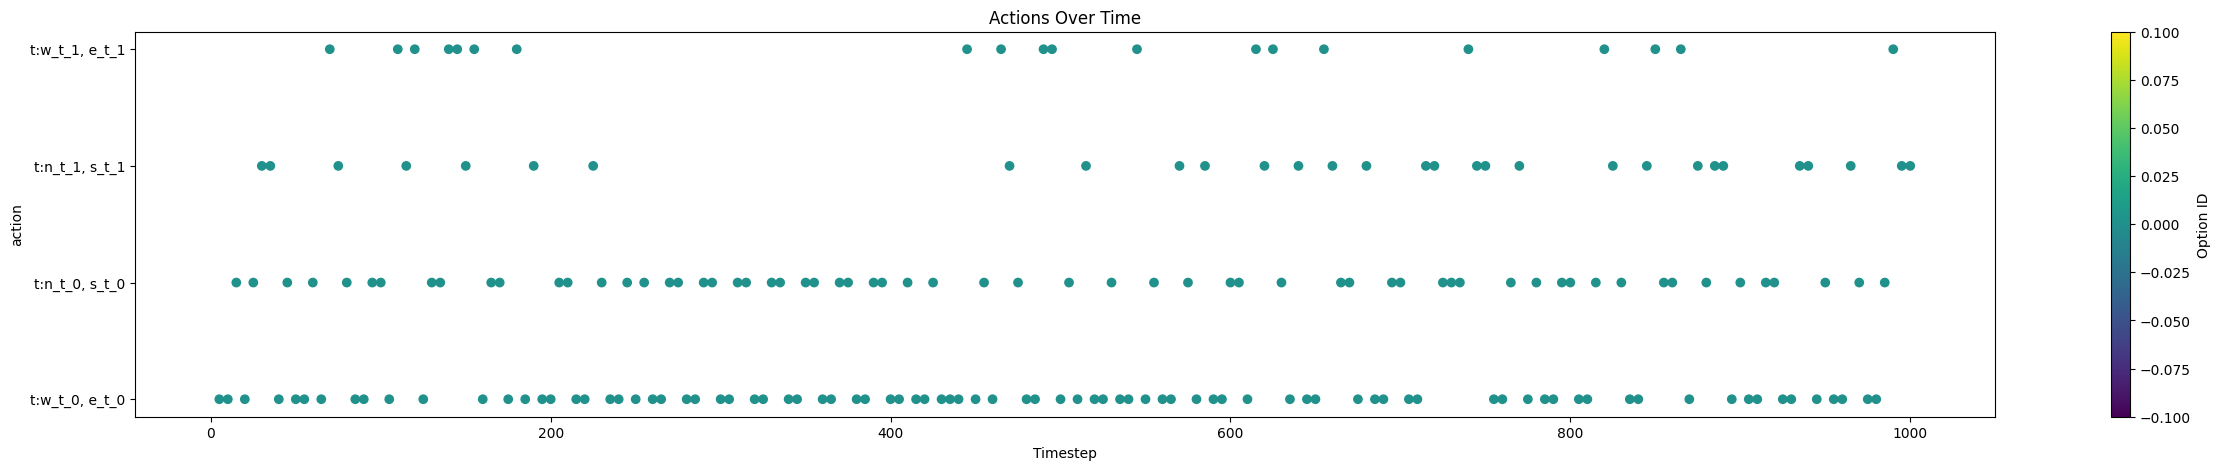

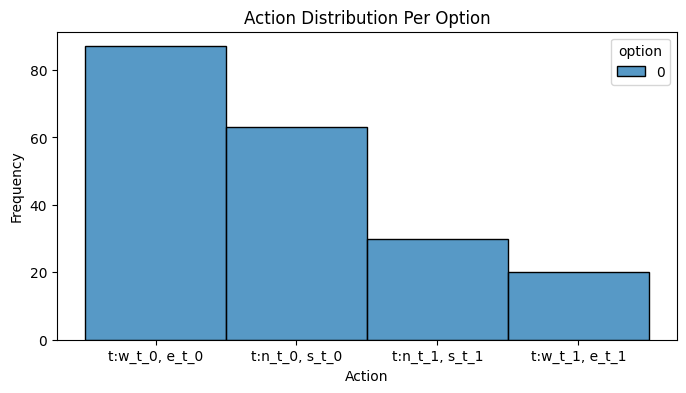

In [125]:
traffic = "custom-2way-single-intersection-low"
df_single_episode, _ = load_data(MODEL_LOW, traffic)
print("Results", MODEL_LOW, traffic)

plt.figure(figsize=(30, 5))
plt.scatter(df_single_episode.index, df_single_episode.translated_action, c=df_single_episode.option)
plt.xlabel("Timestep")
plt.ylabel("action")
plt.title("Actions Over Time")
plt.colorbar(label="Option ID")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_single_episode, x="translated_action", hue="option", multiple="dodge", palette="tab10")
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.title("Action Distribution Per Option")
plt.show()

Loading ./evaluations/a2c_custom-2way-single-intersection-high_100000_steps_custom-2way-single-intersection-low_1_episode.csv
Results a2c_custom-2way-single-intersection-high_100000_steps custom-2way-single-intersection-low


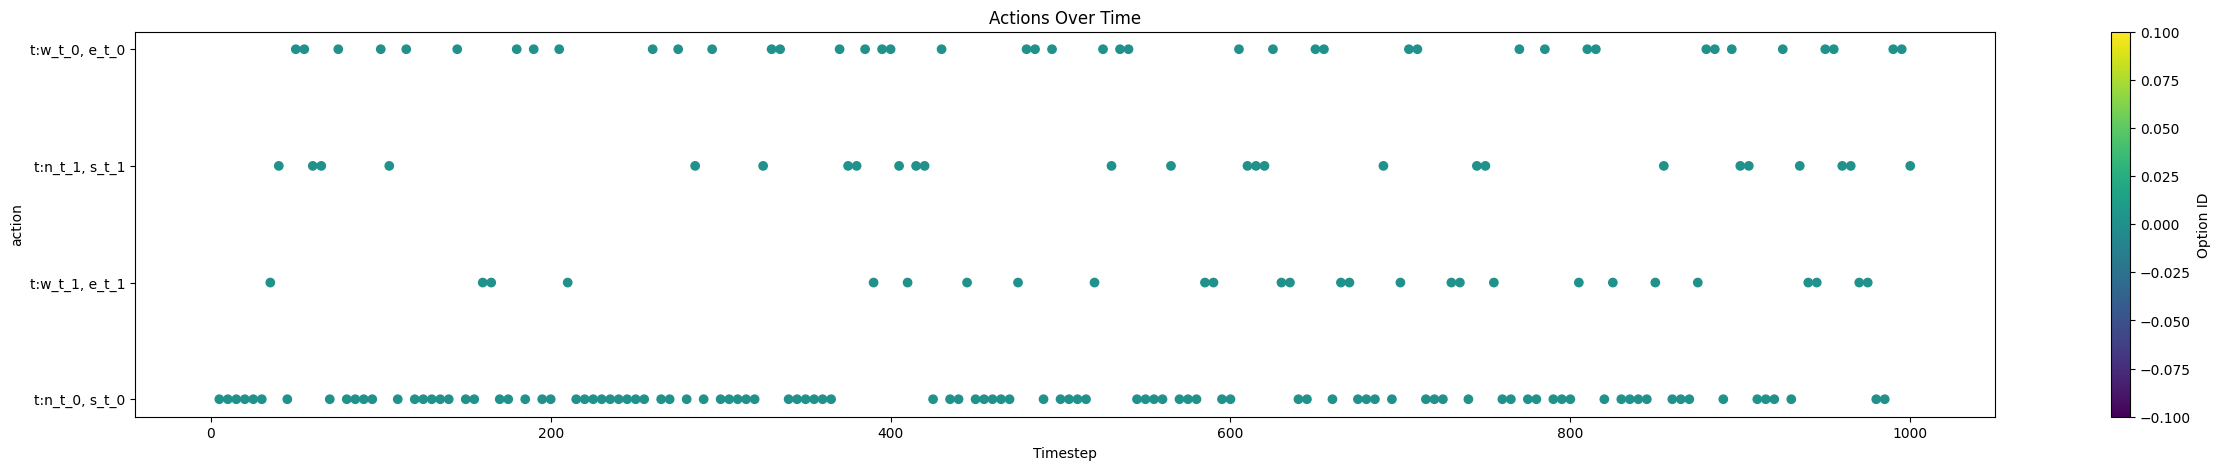

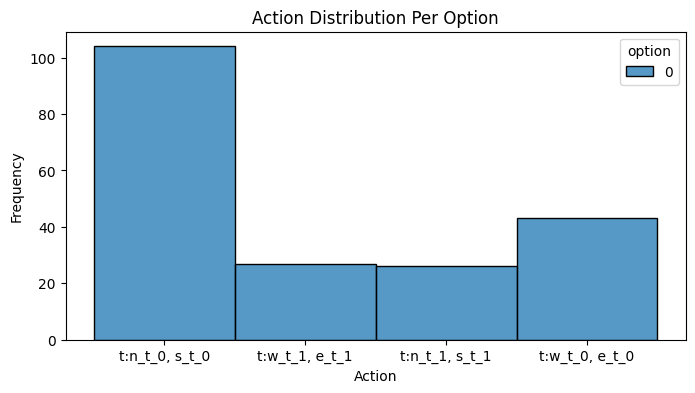

In [126]:
traffic = "custom-2way-single-intersection-low"
df_single_episode, _ = load_data(MODEL_HIGH, traffic)
print("Results", MODEL_HIGH, traffic)

plt.figure(figsize=(30, 5))
plt.scatter(df_single_episode.index, df_single_episode.translated_action, c=df_single_episode.option)
plt.xlabel("Timestep")
plt.ylabel("action")
plt.title("Actions Over Time")
plt.colorbar(label="Option ID")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_single_episode, x="translated_action", hue="option", multiple="dodge", palette="tab10")
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.title("Action Distribution Per Option")
plt.show()

Loading ./evaluations/a2c_custom-2way-single-intersection-low_100000_steps_custom-2way-single-intersection-high_1_episode.csv
Results a2c_custom-2way-single-intersection-low_100000_steps custom-2way-single-intersection-high


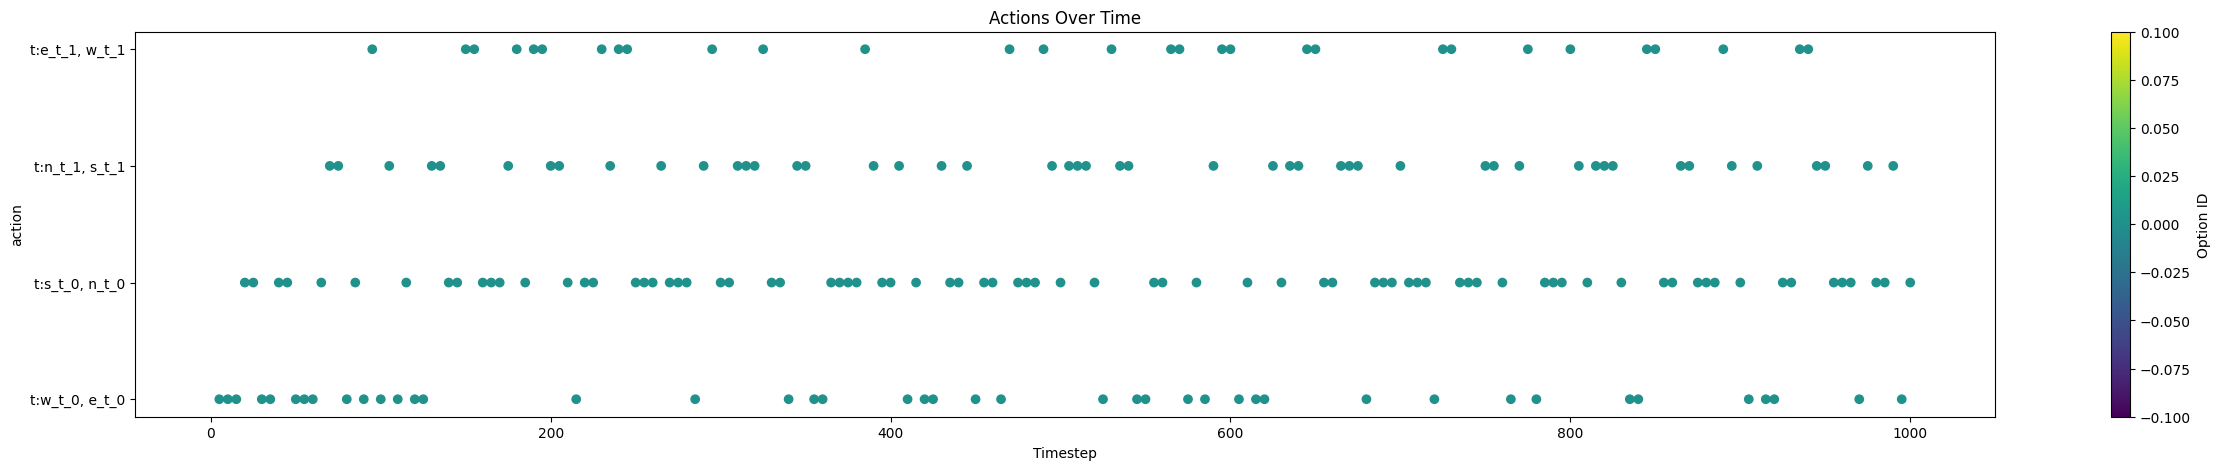

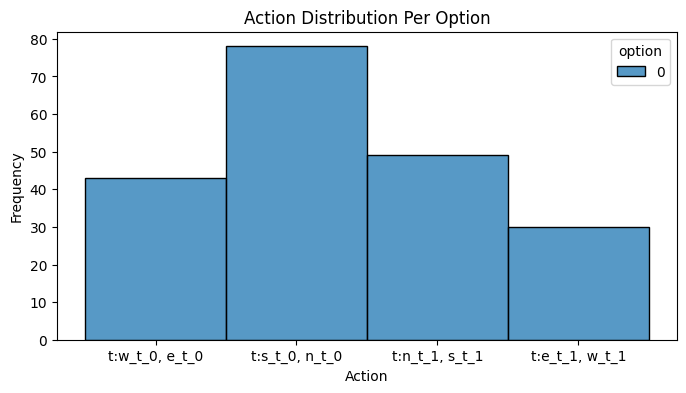

In [127]:
traffic = "custom-2way-single-intersection-high"
df_single_episode, _ = load_data(MODEL_LOW, traffic)
print("Results", MODEL_LOW, traffic)

plt.figure(figsize=(30, 5))
plt.scatter(df_single_episode.index, df_single_episode.translated_action, c=df_single_episode.option)
plt.xlabel("Timestep")
plt.ylabel("action")
plt.title("Actions Over Time")
plt.colorbar(label="Option ID")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_single_episode, x="translated_action", hue="option", multiple="dodge", palette="tab10")
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.title("Action Distribution Per Option")
plt.show()

Loading ./evaluations/a2c_custom-2way-single-intersection-high_100000_steps_custom-2way-single-intersection-high_1_episode.csv
Results a2c_custom-2way-single-intersection-high_100000_steps custom-2way-single-intersection-high


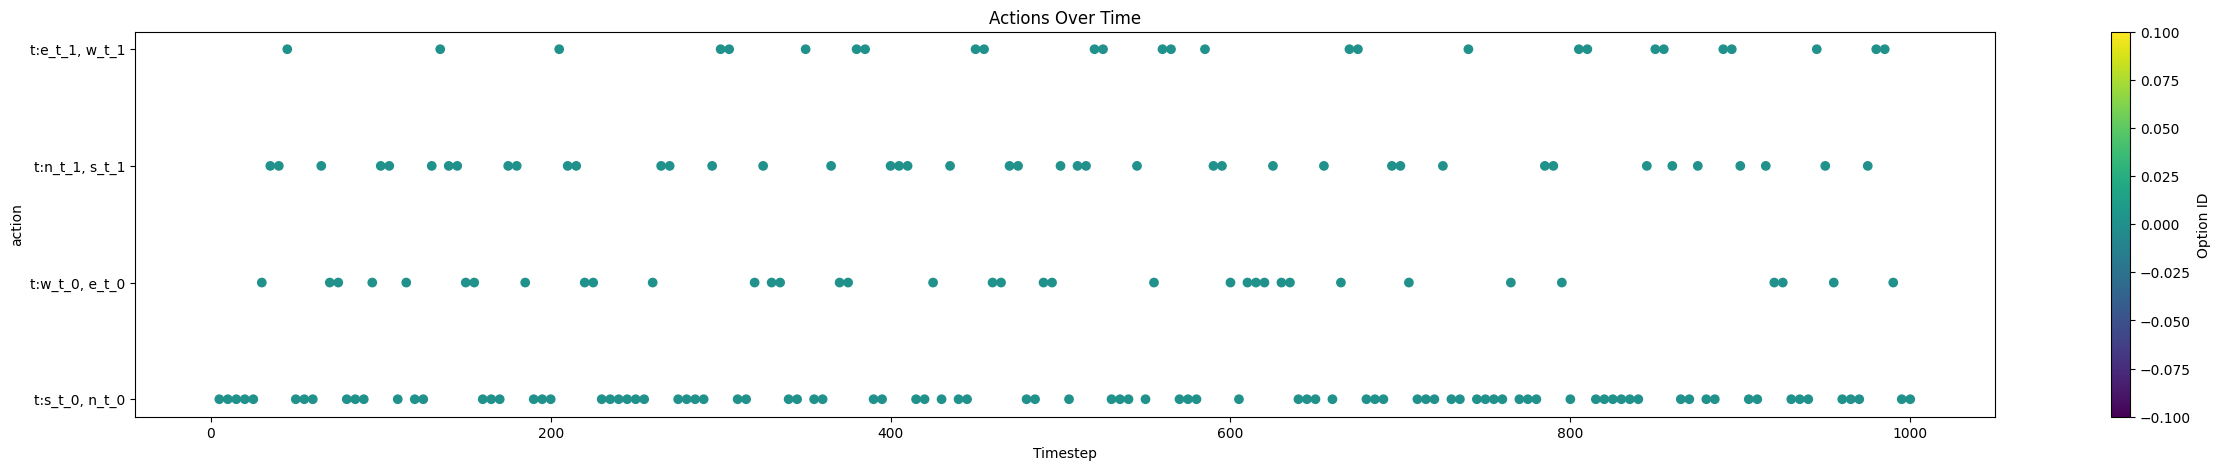

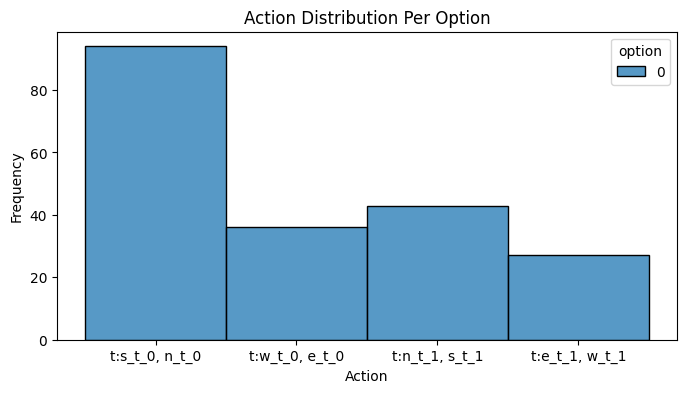

In [128]:
traffic = "custom-2way-single-intersection-high"
df_single_episode, _ = load_data(MODEL_HIGH, traffic)
print("Results", MODEL_HIGH, traffic)
plt.figure(figsize=(30, 5))
plt.scatter(df_single_episode.index, df_single_episode.translated_action, c=df_single_episode.option)
plt.xlabel("Timestep")
plt.ylabel("action")
plt.title("Actions Over Time")
plt.colorbar(label="Option ID")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_single_episode, x="translated_action", hue="option", multiple="dodge", palette="tab10")
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.title("Action Distribution Per Option")
plt.show()

In [142]:
def get_obs(df, index, traffic):
    total_observation = []
    unnested_obs = {}
    
    with open(f"./meta/{traffic}.json") as f:
        meta_data = json.load(f)
    
    for tf_id, observation_dict in json.loads(df.obs.to_list()[index]).items():        
        phase_ids = observation_dict["hist_phase_ids"]
        # min_green = observation_dict["min_green"]
        # density = observation_dict["density"]
        queue = observation_dict["queue"]
        queue_der = observation_dict["queue_der"]
        average_speed = observation_dict["average_speed"]
        waiting_times = []
        for waiting_time in observation_dict["waiting_times"]:
            if waiting_time:
                waiting_times.append(np.mean(waiting_time))
            else:
                waiting_times.append(0)
        observation = np.array(phase_ids + queue + queue_der + waiting_times + [average_speed], dtype=np.float32)
        
        # TODO: check if I can update the phase ids?
        # TODO: double check queue_der
        tf_meta_data = meta_data[tf_id]        
        
        total_observation.extend(observation)
        for key, value in observation_dict.items():           
            if isinstance(value, list):
                for index, item in enumerate(value):
                    suffix = index
                    if key in ["queue"]:
                        suffix = tf_meta_data["lanes"]["cleaned_incoming"][str(index)]
                    unnested_obs[f"{tf_id}_{key}_{suffix}"] = item
            else:
                unnested_obs[f"{tf_id}_{key}"] = value
    total_observation = np.array(total_observation, dtype=np.float32)    


    return total_observation, current_option, unnested_obs

def __get_action_distribution(obs, policy_model):
    """Get the action distribution for the given state and option.

    Args:
        state: State to calculate the action distribution for.
        model: Model to calculate the action distribution with.
        option: Option to calculate the action distribution for.

    Returns:
        array: Numpy array with the action distribution.
    """
    state = {}
    for key, observation_dict in obs.items():
        phase_ids = observation_dict["hist_phase_ids"]
        queue = observation_dict["queue"]
        queue_der = observation_dict["queue_der"]
        average_speed = observation_dict["average_speed"]
        waiting_times = []
        for waiting_time in observation_dict["waiting_times"]:
            if waiting_time:
                waiting_times.append(np.mean(waiting_time))
            else:
                waiting_times.append(0)
        combined_obs = np.array(phase_ids + queue + queue_der + waiting_times + [average_speed], dtype=np.float32)
        state[key] = torch.tensor([combined_obs], dtype=torch.float32, device="cuda")
    return policy_model.get_distribution(state).distribution[0].probs.cpu().detach().numpy()[0]


def hellinger_distance(state, model_1, model_2) -> float:
    """Calculate the hellinger distance between the intra-option policies of the model
    for the given state.
    This as defined in the paper "Disentangling Options with Hellinger Distance Regularizer"

    Args:
        states: The states for which to calculate the hellinger distance.
        model: The option critic model to calculate the distance for.

    Returns:
        float: Helling distance loss
    """
    p_dist = __get_action_distribution(state, model_1.policy)
    q_dist = __get_action_distribution(state, model_2.policy)
    summation = np.sum((np.sqrt(p_dist) - np.sqrt(q_dist)) ** 2)
    hd = math.sqrt(summation) / math.sqrt(2)
    return hd


In [130]:
model_high = stable_baselines3.A2C.load(
    f"./models/{MODEL_HIGH}.zip"
)

model_low = stable_baselines3.A2C.load(
    f"./models/{MODEL_LOW}.zip"
)

In [145]:
obs

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)

In [156]:
traffic = "custom-2way-single-intersection-high"
df_single_episode_high, _ = load_data(MODEL_HIGH, traffic)

results = []
distances = []
for index in range(df_single_episode_high.shape[0]):
    obs, current_option, unnested_dict = get_obs(df_single_episode_high, index, traffic)
    results.append({
        "step": index*5,
        "action_high": model_high.predict({"t": obs})[0][0],
        "action_low": model_low.predict({"t": obs})[0][0]
    })
    hd_distance = hellinger_distance(json.loads(df_single_episode_high.obs.to_list()[index]), model_low, model_high)
    distances.append(hd_distance)
    
df_action_comparision = pd.DataFrame(results)
# df_action_comparision = df_action_comparision.set_index('step')
print(df_action_comparision.shape)
print("equal", df_action_comparision[df_action_comparision.action_high == df_action_comparision.action_low].shape[0])
print(np.mean(distances), np.std(distances))
print(np.max(distances), np.min(distances))

Loading ./evaluations/a2c_custom-2way-single-intersection-high_100000_steps_custom-2way-single-intersection-high_1_episode.csv
(200, 3)
equa 112


In [157]:
traffic = "custom-2way-single-intersection-low"
df_single_episode_high, _ = load_data(MODEL_HIGH, traffic)

results = []
distances = []
for index in range(df_single_episode_high.shape[0]):
    obs, current_option, unnested_dict = get_obs(df_single_episode_high, index, traffic)
    results.append({
        "step": index*5,
        "action_high": model_high.predict({"t": obs})[0][0],
        "action_low": model_low.predict({"t": obs})[0][0]
    })
    hd_distance = hellinger_distance(json.loads(df_single_episode_high.obs.to_list()[index]), model_low, model_high)
    distances.append(hd_distance)
    
df_action_comparision = pd.DataFrame(results)
# df_action_comparision = df_action_comparision.set_index('step')
print(df_action_comparision.shape)
print("equal", df_action_comparision[df_action_comparision.action_high == df_action_comparision.action_low].shape[0])
print(np.mean(distances), np.std(distances))
print(np.max(distances), np.min(distances))

Loading ./evaluations/a2c_custom-2way-single-intersection-high_100000_steps_custom-2way-single-intersection-low_1_episode.csv
(200, 3)
equal 106
0.41484013831975247 0.36114630196635844
0.9886600235944991 0.005049157135377749


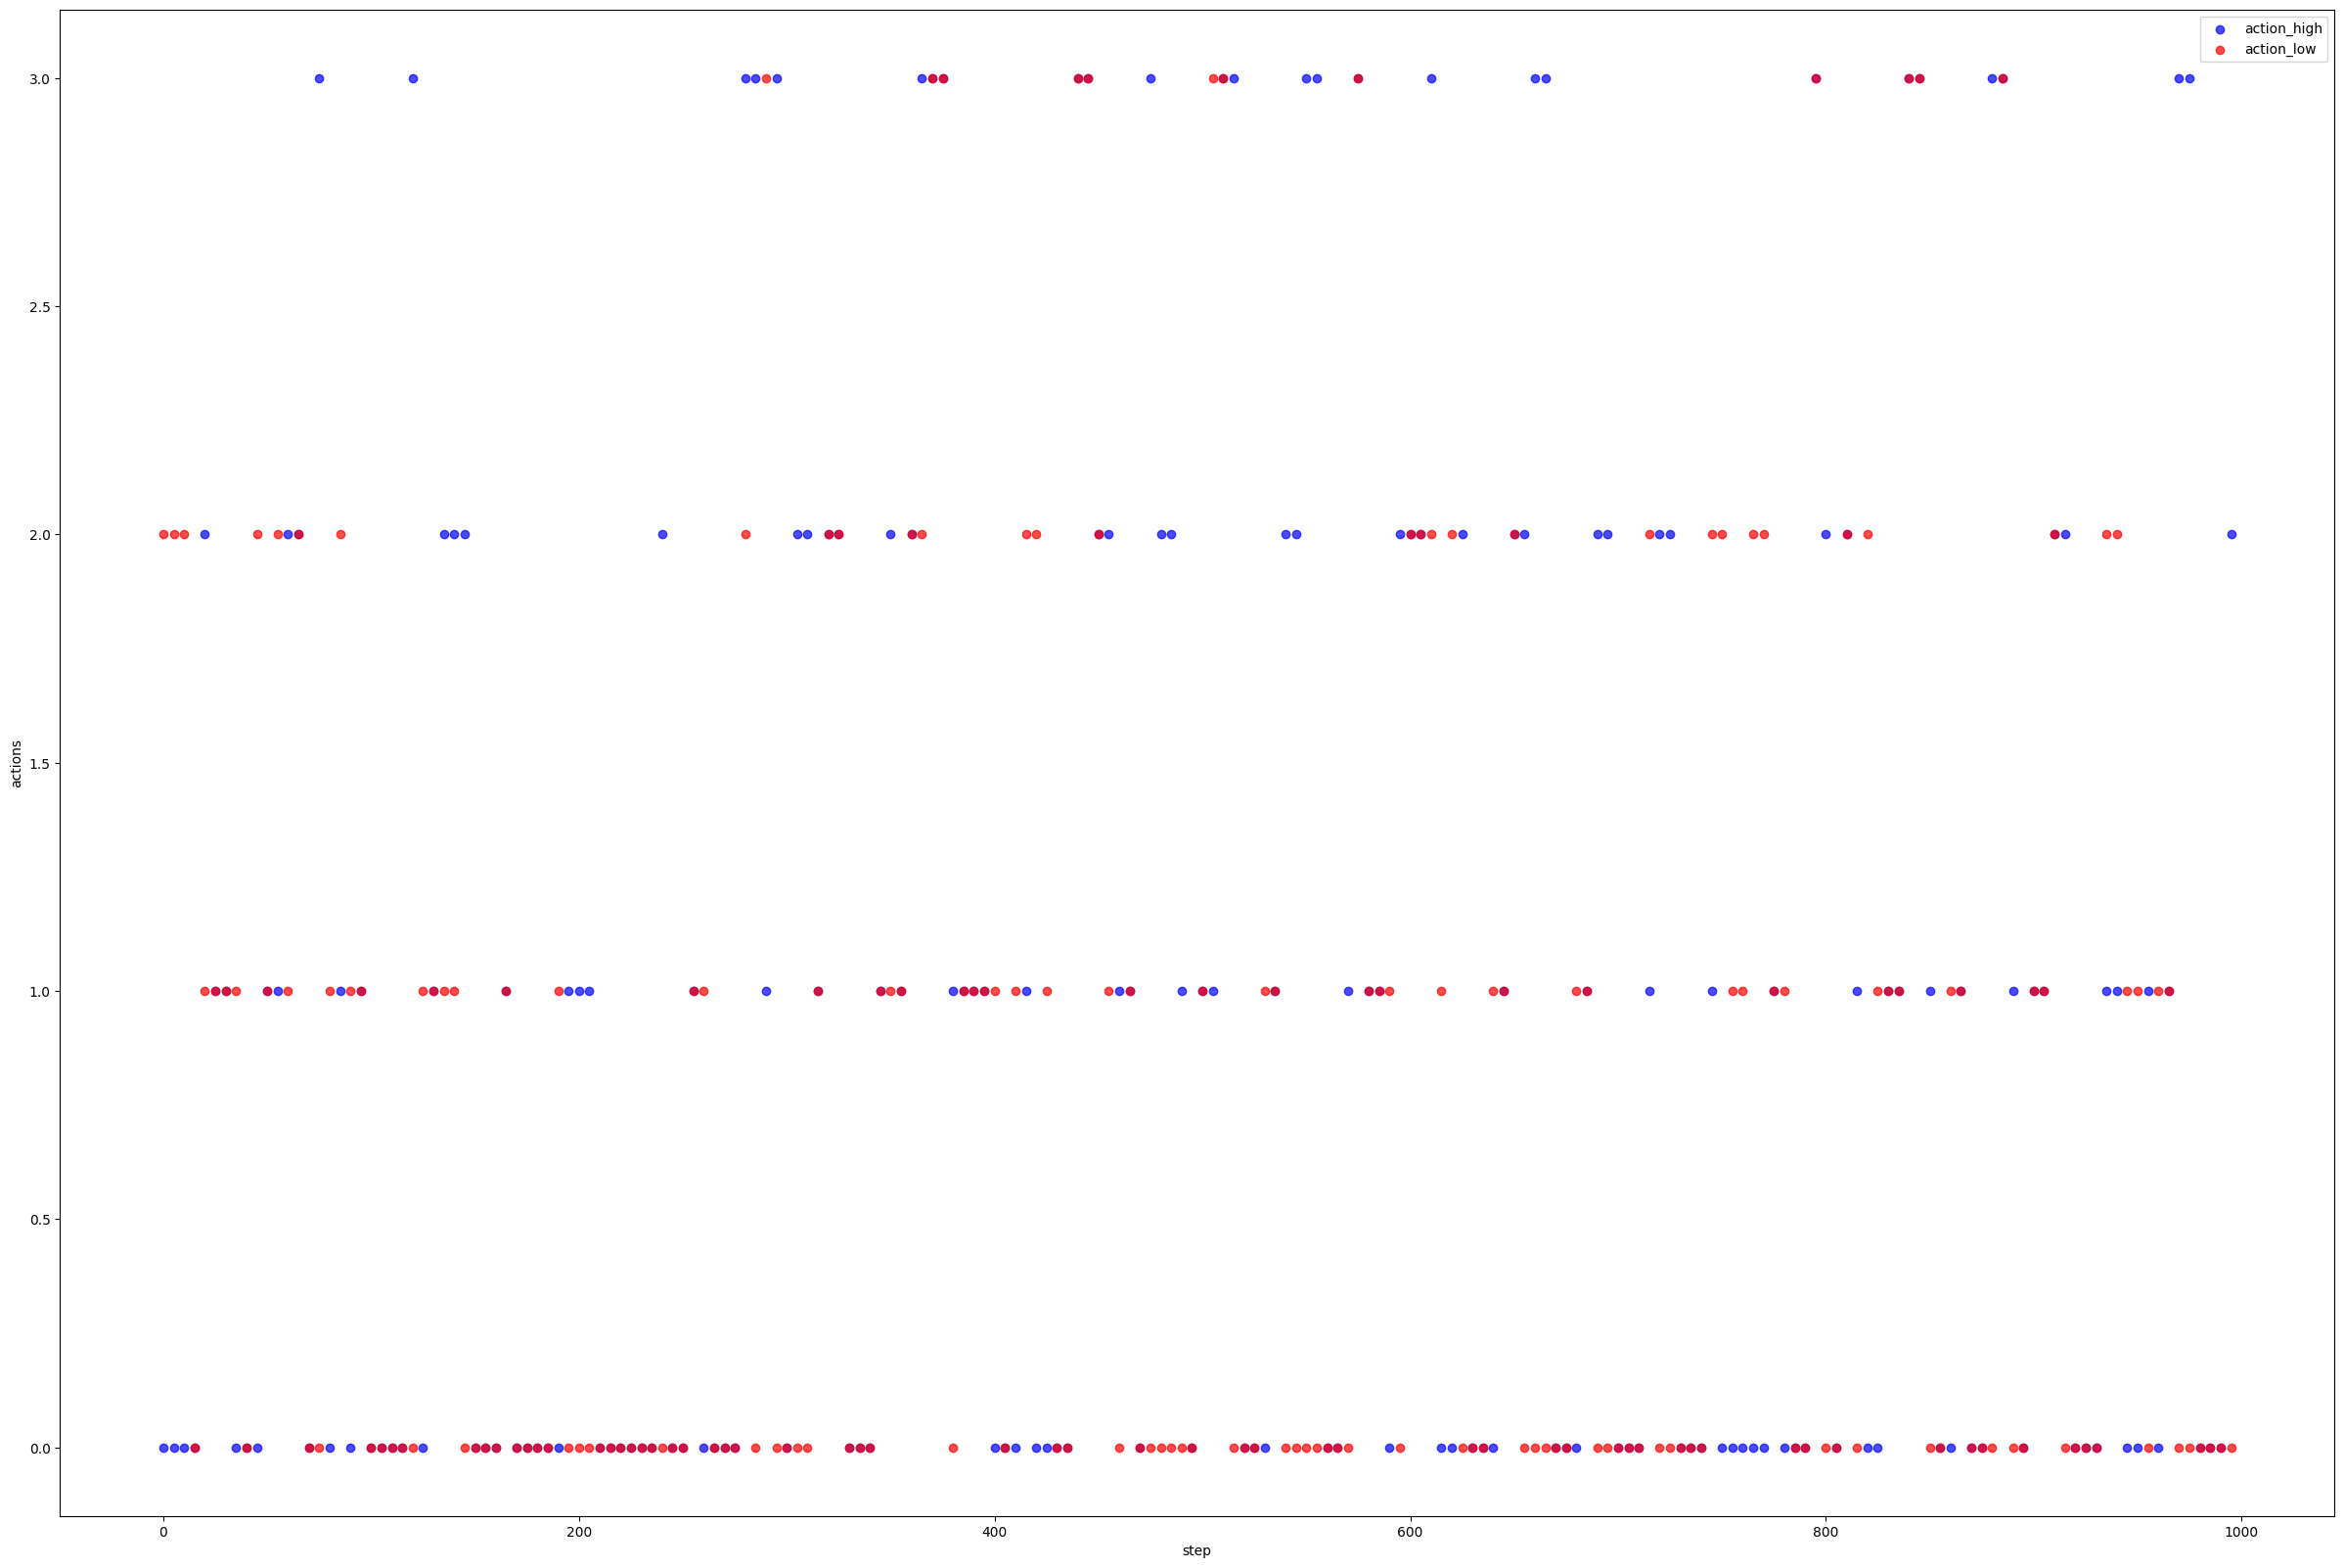

In [138]:
plt.figure(figsize=(30, 20))

# Scatter plot for Column2
plt.scatter(df_action_comparision['step'], df_action_comparision['action_high'], color='blue', label='action_high', alpha=0.7)

# Scatter plot for Column3
plt.scatter(df_action_comparision['step'], df_action_comparision['action_low'], color='red', label='action_low', alpha=0.7)

# Labels and title
plt.xlabel('step')
plt.ylabel('actions')

# Show legend
plt.legend()

# Show plot
plt.show()

In [139]:

def find_repeating_patterns(df, column, window_size):
    """
    Find repeating sequences of length `window_size` in a given column of a DataFrame.
    """
    patterns = defaultdict(list)
    series = df[column].tolist()

    # Store occurrences of each pattern
    for i in range(len(series) - window_size + 1):
        pattern = tuple(series[i : i + window_size])  # Convert slice to tuple (hashable)
        patterns[pattern].append(i)  # Store start index of pattern

    # Filter only repeating patterns
    repeating_patterns = {k: len(v) for k, v in patterns.items() if len(v) > 1}
    return repeating_patterns

repeating_patterns_high = find_repeating_patterns(df_action_comparision, 'action_high', window_size=4)
repeating_patterns_low = find_repeating_patterns(df_action_comparision, 'action_low', window_size=4)

In [140]:
df_repeating_high = pd.DataFrame([{"cycle": key, "count": value}
                                 for key, value in repeating_patterns_high.items()])
df_repeating_low = pd.DataFrame([{"cycle": key, "count": value}
                                 for key, value in repeating_patterns_low.items()])
df_repeating_comparision = df_repeating_high.merge(df_repeating_low, on="cycle", how="outer")

In [141]:
df_repeating_comparision

,cycle,count_x,count_y
0,"(0, 0, 0, 0)",11.0,31.0
1,"(0, 0, 0, 2)",3.0,4.0
2,"(2, 1, 1, 0)",2.0,3.0
3,"(1, 1, 0, 0)",4.0,8.0
4,"(1, 0, 0, 0)",9.0,10.0
5,"(0, 0, 0, 1)",12.0,10.0
6,"(0, 0, 1, 1)",4.0,8.0
7,"(0, 1, 1, 2)",2.0,2.0
8,"(1, 1, 2, 2)",2.0,2.0
9,"(1, 2, 2, 0)",5.0,NaN


In [15]:
results = []
for _, row in df_single_episode.iterrows():
    obs = [float(s.strip()) for s in row.obs.split(',')]
    state = agent.get_state(to_tensor(obs))
    option_distributions_dict = {}
    for option in range(0, df_single_episode.option.max() + 1):
        dist = get_action_dist(agent, state, option)[0]
        for i, value in enumerate(dist):
            if i not in option_distributions_dict:
                option_distributions_dict[i] = {'action': i}
            option_distributions_dict[i][f'prob_option_{option}'] = value        
    results.append(option_distributions_dict)
avg_dist = {key: {'action': key, 'prob_option_0': 0, 'prob_option_1': 0} for key in results[0].keys()}
for item in results:
    for key, value in item.items():
        for option in range(n_options):
            option_prob = f'prob_option_{option}'
            avg_dist[key][option_prob] += value[option_prob]
for _, value in avg_dist.items():
    for option in range(n_options):
        option_prob = f'prob_option_{option}'
        value[option_prob] = value[option_prob] / len(results)
df_avg_action_distributions = pd.DataFrame(list(avg_dist.values()))
px.bar(
    data_frame = df_avg_action_distributions,
    x = "action",
    y = [f'prob_option_{option}' for option in range(n_options)],
    opacity = 0.9,
    orientation = "v",
    barmode = 'group',
)

NameError: name 'n_options' is not defined

In [ ]:
results = []
for _, row in df_single_episode.iterrows():
    obs = [float(s.strip()) for s in row.obs.split(',')]
    state = agent.get_state(to_tensor(obs))
    option_distributions_dict = {}
    for option in range(0, df_single_episode.option.max() + 1):
        dist = get_action_dist(agent, state, option)[0]
        for i, value in enumerate(dist):
            if i not in option_distributions_dict:
                option_distributions_dict[i] = {'action': i}
            option_distributions_dict[i][f'prob_option_{option}'] = value        
    results.append(option_distributions_dict)
avg_dist = {key: {'action': key, 'prob_option_0': 0, 'prob_option_1': 0} for key in results[0].keys()}
n_options = 2
for item in results:
    for key, value in item.items():
        for option in range(n_options):
            option_prob = f'prob_option_{option}'
            avg_dist[key][option_prob] += value[option_prob]
for _, value in avg_dist.items():
    for option in range(n_options):
        option_prob = f'prob_option_{option}'
        value[option_prob] = value[option_prob] / len(results)
df_avg_action_distributions = pd.DataFrame(list(avg_dist.values()))
px.bar(
    data_frame = df_avg_action_distributions,
    x = "action",
    y = [f'prob_option_{option}' for option in range(n_options)],
    opacity = 0.9,
    orientation = "v",
    barmode = 'group',
)

In [ ]:
df_action_encoded = pd.get_dummies(df_single_episode[['action', 'option']], columns=['action', ])

In [ ]:
df_action_encoded.groupby('option').sum()

In [ ]:
lanes = ['n_t_0', 'n_t_1', 'e_t_0', 'e_t_1', 's_t_0', 's_t_1', 'w_t_0', 'w_t_1']
          0          1         2       3         4         5     6        7

In [ ]:
# backup
option_distributions = []
for option in range(0, df_single_episode.option.max() + 1):
    dist = get_action_dist(agent, state, option)[0]
    for i, value in enumerate(dist):
        dist_dict = {
            'option': option
        }
        dist_dict[f'action'] = i
        dist_dict[f'prob'] = value
        option_distributions.append(dist_dict)
df_option_distributions = pd.DataFrame(option_distributions)
fig, ax = plt.subplots()

for key, grp in df_option_distributions.groupby(['option']):
    key = key[0]
    ax = grp.plot(ax=ax, kind='line', x='action', y='prob', label=key)

plt.legend(loc='best')
plt.show()